# OpenAI's o1 Reasoning Model vs. GPT

## Introduction
OpenAI's o1 reasoning model is designed for complex problem-solving, data analysis, and image interpretation by simulating a multi-step thought process before generating responses. Unlike traditional GPT models, which produce output in a single pass, reasoning models use internal **reasoning tokens** to explore multiple approaches before finalizing an answer.
<p align="center">
    <img src="https://cdn.openai.com/API/images/guides/reasoning_tokens.png" alt="Reasoning Tokens" width="600">
</p>  

*Source: [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning)*

**Key Differences: o1 Reasoning Model vs. GPT**
- Multi-step reasoning: o1 evaluates different solutions before selecting the best response.
- Deeper analytical capabilities: Optimized for complex data interpretation tasks.
- Context-aware image analysis: Provides more structured and insightful image descriptions.
- Reasoning Effort Control: Users can adjust the depth of reasoning (`low`, `medium`, `high`).


For more details, refer to the [OpenAI Reasoning Models Guide](https://platform.openai.com/docs/guides/reasoning).


## Purchase and Store API Key

You need to **purchase** your [OpenAI](https://openai.com/) API key and store it securely, such as in **AWS Secrets Manager**.

- **Key Name:** `api_key`  
- **Key Value:** `<your OpenAI API key>`  
- **Secret Name:** `openai`  

## Install Python Libraries

- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.

In [1]:
pip install openai -q

Note: you may need to restart the kernel to use updated packages.


## Import Required Libraries

The following libraries are used in this notebook:

- **boto3**: AWS SDK for Python, used to interact with AWS services.
- **json**: Standard Python library for handling JSON data.
- **IPython.display**: Provides tools to display images, Markdown content, and other rich media in Jupyter Notebook.
- **openai**: Used to call `o1` and `GPT` models for data analysis and image interpretation.
- **pandas**: A powerful library for data manipulation and analysis.
- **pprint**: Pretty prints data structures for better readability.

In [2]:
import boto3
import json
from IPython.display import display, Image, Markdown
from openai import OpenAI
import pandas as pd
from pprint import pprint

## Retrieve API Keys Securely from AWS Secrets Manager

The following function, `get_secret()`, retrieves a secret from **AWS Secrets Manager**. This is a secure way to store and access sensitive credentials, such as API keys, without hardcoding them into the script

In [3]:
def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

## Initialize OpenAI Client

The following code initializes the OpenAI client using a securely stored API key retrieved from AWS Secrets Manager.

In [4]:
client = OpenAI(api_key= get_secret('openai')['api_key'])

## Load and Analyze the Diamonds Dataset

This notebook uses the **diamonds dataset ([diamonds.csv](https://github.com/lbsocial/data-analysis-with-generative-ai/blob/main/diamonds.csv))**, which contains detailed attributes of diamonds, including weight, color, clarity, and price.

One interesting pattern in the dataset is that **diamonds with "IF" (Internally Flawless) clarity tend to have the lowest average price** compared to other clarity grades. This observation is counterintuitive, as one might expect the highest-clarity diamonds to be the most expensive.

In [5]:
# Load CSV as plain text
with open('diamonds.csv', 'r', encoding='utf-8') as f:
    data_text = f.read()

print(data_text[:500])  # show first 500 characters

﻿IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
1,0.3,D,VS2,GIA,1302
2,0.3,E,VS1,GIA,1510
3,0.3,G,VVS1,GIA,1510
4,0.3,G,VS1,GIA,1260
5,0.31,D,VS1,GIA,1641
6,0.31,E,VS1,GIA,1555
7,0.31,F,VS1,GIA,1427
8,0.31,G,VVS2,GIA,1427
9,0.31,H,VS2,GIA,1126
10,0.31,I,VS1,GIA,1126
11,0.32,F,VS1,GIA,1468
12,0.32,G,VS2,GIA,1202
13,0.33,E,VS2,GIA,1327
14,0.33,I,VS2,GIA,1098
15,0.34,E,VS1,GIA,1693
16,0.34,F,VS1,GIA,1551
17,0.34,G,VS1,GIA,1410
18,0.34,G,VS2,GIA,1269
19,0.34,H,VS1,GIA,1316
20,0.34,H,VS2,GIA,1222
21,0.35,E,VS


## Generate Data Analysis Prompt for OpenAI Model

To investigate why diamonds with **IF (Internally Flawless) clarity** have the **lowest average price**, we generate a structured prompt for the OpenAI model. The model will analyze the dataset and generate insights, including **Python code for visualizations**.


In [6]:
data_prompt = f"""Analyze the provided data and determine 
                Why diamonds with IF clarity have the lowest average price. 
                You may use Python code to support your conclusion. 
                Data: {data_text}"""
# print(prompt)

## Define a Function to Get Assistance from OpenAI GPT-4o

The following function, `openai_gpt_help()`, sends a prompt to OpenAI's **GPT-4o model** and returns a response. It also prints the number of tokens used in the request.

In [7]:
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [8]:
gpt_result = openai_gpt_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=5032, prompt_tokens=4708, '
 'total_tokens=9740, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, '
 'cached_tokens=4608))')


In [9]:
display(Markdown(gpt_result))

To analyze why diamonds with IF (Internally Flawless) clarity have the lowest average price, we can use Python to process the data and calculate the average price for each clarity category. Let's write a Python script to perform this analysis.

```python
import pandas as pd
from io import StringIO

# Data provided as a string
data = """
IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
1,0.3,D,VS2,GIA,1302
2,0.3,E,VS1,GIA,1510
3,0.3,G,VVS1,GIA,1510
4,0.3,G,VS1,GIA,1260
5,0.31,D,VS1,GIA,1641
6,0.31,E,VS1,GIA,1555
7,0.31,F,VS1,GIA,1427
8,0.31,G,VVS2,GIA,1427
9,0.31,H,VS2,GIA,1126
10,0.31,I,VS1,GIA,1126
11,0.32,F,VS1,GIA,1468
12,0.32,G,VS2,GIA,1202
13,0.33,E,VS2,GIA,1327
14,0.33,I,VS2,GIA,1098
15,0.34,E,VS1,GIA,1693
16,0.34,F,VS1,GIA,1551
17,0.34,G,VS1,GIA,1410
18,0.34,G,VS2,GIA,1269
19,0.34,H,VS1,GIA,1316
20,0.34,H,VS2,GIA,1222
21,0.35,E,VS1,GIA,1738
22,0.35,F,VS1,GIA,1593
23,0.35,G,VS1,GIA,1447
24,0.35,H,VS2,GIA,1255
25,0.36,F,VS1,GIA,1635
26,0.36,H,VVS2,GIA,1485
27,0.37,F,VS2,GIA,1420
28,0.37,H,VS1,GIA,1420
29,0.4,F,VS1,GIA,1911
30,0.4,H,VS1,GIA,1525
31,0.41,F,VS1,GIA,1956
32,0.43,H,VVS2,GIA,1747
33,0.45,I,VS1,GIA,1572
34,0.46,E,VVS2,GIA,2942
35,0.48,G,VVS2,GIA,2532
36,0.5,E,VS1,GIA,3501
37,0.5,E,VS1,GIA,3501
38,0.5,F,VVS2,GIA,3501
39,0.5,F,VS1,GIA,3293
40,0.5,G,VS1,GIA,3016
41,0.51,F,VVS2,GIA,3567
42,0.51,G,VS1,GIA,3205
43,0.52,D,VS2,GIA,3490
44,0.52,E,VS1,GIA,3635
45,0.52,F,VVS2,GIA,3635
46,0.52,F,VS1,GIA,3418
47,0.53,D,VS1,GIA,3921
48,0.53,F,VVS2,GIA,3701
49,0.53,F,VS1,GIA,3480
50,0.53,G,VVS2,GIA,3407
51,0.54,E,VS1,GIA,3767
52,0.54,F,VVS1,GIA,4066
53,0.55,E,VVS2,GIA,4138
54,0.55,F,VS1,GIA,3605
55,0.55,G,VVS2,GIA,3529
56,0.56,F,VS1,GIA,3667
57,0.56,I,VVS2,GIA,2892
58,0.57,G,VVS2,GIA,3651
59,0.59,G,VVS2,GIA,3773
60,0.6,F,VS1,GIA,4291
61,0.62,E,VVS1,GIA,5845
62,0.63,G,VVS2,GIA,4401
63,0.64,G,VVS1,GIA,4759
64,0.66,H,VVS1,GIA,4300
65,0.7,F,VS1,GIA,5510
66,0.7,G,VS1,GIA,5122
67,0.7,H,VVS2,GIA,5122
68,0.7,I,VS2,GIA,3861
69,0.71,F,VVS2,GIA,5881
70,0.71,F,VS1,GIA,5586
71,0.71,F,VS2,GIA,5193
72,0.71,H,VVS2,GIA,5193
73,0.72,F,VS2,GIA,5263
74,0.8,I,VVS2,GIA,5441
75,0.82,I,VS2,GIA,4948
76,0.84,H,VS2,GIA,5705
77,0.85,F,VS2,GIA,6805
78,0.86,H,VVS2,GIA,6882
79,0.89,H,VS1,GIA,6709
80,0.9,I,VVS2,GIA,6682
81,0.5,E,VS1,GIA,3501
82,0.5,G,VVS1,GIA,3432
83,0.51,F,VVS1,GIA,3851
84,0.55,H,IF,GIA,3605
85,0.56,E,VS1,GIA,3900
86,0.57,H,VVS1,GIA,3415
87,0.6,H,IF,GIA,4291
88,0.63,E,IF,GIA,6512
89,0.7,E,VS1,GIA,5800
90,0.7,F,VVS1,GIA,6285
91,0.7,F,VS2,GIA,5122
92,0.7,F,VS2,GIA,5122
93,0.7,G,VS1,GIA,5122
94,0.7,H,VVS2,GIA,5122
95,0.71,D,VS1,GIA,6372
96,0.71,E,VS1,GIA,5881
97,0.71,H,VVS2,GIA,5193
98,0.72,E,VS1,GIA,5961
99,0.72,H,VVS1,GIA,5662
100,0.73,E,VS2,GIA,5738
101,0.73,H,VS1,GIA,5030
102,0.73,H,VS1,GIA,5030
103,0.73,I,VVS1,GIA,4727
104,0.73,I,VS1,GIA,4221
105,0.74,G,VVS2,GIA,5815
106,0.74,H,VS2,GIA,4585
107,0.75,D,VVS2,GIA,7368
108,0.75,I,VVS2,GIA,4667
109,0.75,I,VS1,GIA,4355
110,0.76,D,IF,GIA,9885
111,0.77,F,VVS1,GIA,6919
112,0.78,H,VS1,GIA,5386
113,0.8,I,VS2,GIA,4832
114,0.83,E,VS2,GIA,7156
115,0.9,F,VS1,GIA,7680
116,1,D,VVS1,GIA,15582
117,1,D,VS1,GIA,11419
118,1,E,VS1,GIA,10588
119,1,E,VS2,GIA,9757
120,1,F,IF,GIA,13913
121,1,F,VVS2,GIA,10588
122,1,F,VS1,GIA,10713
123,1,F,VS2,GIA,9480
124,1,G,VVS2,GIA,9896
125,1,G,VS1,GIA,9619
126,1,G,VS2,GIA,9169
127,1,G,VS2,GIA,9203
128,1,H,VS2,GIA,8788
129,1,I,VS1,GIA,8095
130,1,I,VS2,GIA,7818
131,1.01,D,VVS1,GIA,16008
132,1.01,E,VS1,GIA,10692
133,1.01,E,VS2,GIA,9853
134,1.01,F,VS1,GIA,10272
135,1.01,F,VS2,GIA,9573
136,1.01,H,VS1,GIA,9153
137,1.01,H,VS2,GIA,8873
138,1.01,I,VVS1,GIA,8873
139,1.01,I,VVS2,GIA,8455
140,1.01,I,VS2,GIA,7895
141,1.02,F,VS1,GIA,10372
142,1.02,F,VS2,GIA,9666
143,1.02,G,VVS2,GIA,10090
144,1.03,E,VS1,GIA,10900
145,1.04,F,VS1,GIA,10571
146,1.04,I,IF,GIA,9563
147,1.05,I,VVS2,GIA,8781
148,1.06,G,VS2,GIA,9743
149,1.06,H,VS2,GIA,9302
150,1.07,I,VVS2,GIA,8945
151,1.1,H,VS2,GIA,9646
152,0.18,F,VVS1,IGI,823
153,0.18,F,VVS2,IGI,765
154,0.18,G,IF,IGI,803
155,0.18,G,IF,IGI,803
156,0.18,G,VVS2,IGI,705
157,0.18,H,IF,IGI,725
158,0.19,D,VVS2,IGI,967
159,0.19,E,IF,IGI,1050
160,0.19,F,IF,IGI,967
161,0.19,F,VVS1,IGI,863
162,0.19,F,VVS2,IGI,800
163,0.19,G,IF,IGI,842
164,0.19,G,VVS1,IGI,800
165,0.19,H,IF,IGI,758
166,0.2,D,VS1,IGI,880
167,0.2,G,IF,IGI,880
168,0.2,G,VS1,IGI,705
169,0.2,G,VS2,IGI,638
170,0.21,D,VS1,IGI,919
171,0.21,E,IF,IGI,1149
172,0.21,F,IF,IGI,1057
173,0.21,G,IF,IGI,919
174,0.22,E,IF,IGI,1198
175,0.23,E,IF,IGI,1248
176,0.23,F,IF,IGI,1147
177,0.23,G,IF,IGI,995
178,0.24,H,IF,IGI,1108
179,0.25,F,IF,IGI,1485
180,0.25,G,IF,IGI,1283
181,0.25,H,IF,IGI,1149
182,0.25,I,IF,IGI,1082
183,0.26,F,IF,IGI,1539
184,0.26,F,VVS1,IGI,1365
185,0.26,F,VVS2,IGI,1260
186,0.26,I,IF,IGI,1121
187,0.27,F,IF,IGI,1595
188,0.27,H,IF,IGI,1233
189,0.28,I,IF,IGI,1199
190,0.29,G,IF,IGI,1471
191,0.29,I,IF,IGI,1238
192,0.3,E,VVS2,IGI,1580
193,0.3,F,VVS2,IGI,1459
194,0.3,G,VVS1,IGI,1459
195,0.3,H,VVS2,IGI,1218
196,0.3,I,IF,IGI,1299
197,0.31,E,VVS2,IGI,1628
198,0.31,F,VVS1,IGI,1628
199,0.31,I,IF,IGI,1337
200,0.32,H,IF,IGI,1462
201,0.33,H,IF,IGI,1503
202,0.34,F,VVS1,IGI,1773
203,0.34,F,VVS2,IGI,1636
204,0.35,F,VVS1,IGI,1821
205,0.35,G,VVS2,IGI,1540
206,0.4,G,IF,IGI,2276
207,0.41,I,VVS1,IGI,1616
208,0.41,I,VVS2,IGI,1506
209,0.47,F,VVS2,IGI,2651
210,0.48,F,VS1,IGI,2383
211,0.5,G,IF,IGI,3652
212,0.51,E,VVS2,IGI,3722
213,0.51,F,VVS1,IGI,3722
214,0.52,I,IF,IGI,3095
215,0.55,F,VVS2,IGI,3706
216,0.56,E,VVS2,IGI,4070
217,0.56,G,VVS2,IGI,3470
218,0.58,E,VVS1,IGI,4831
219,0.58,F,VVS1,IGI,4209
220,0.58,G,VVS1,IGI,3821
221,0.7,G,VVS1,IGI,5607
222,0.7,G,VVS2,IGI,5326
223,0.71,D,VS1,IGI,6160
224,0.76,F,VVS2,IGI,6095
225,0.78,G,VVS2,IGI,5937
226,1,H,VVS2,IGI,9342
227,1.01,G,VS1,IGI,9713
228,1.01,H,VS2,IGI,8873
229,1.01,I,VS1,IGI,8175
230,0.5,F,VVS1,HRD,3778
231,0.5,G,VVS1,HRD,3432
232,0.51,F,VVS1,HRD,3851
233,0.52,E,VS2,HRD,3346
234,0.52,H,VVS1,HRD,3130
235,0.53,F,VVS1,HRD,3995
236,0.53,F,VVS2,HRD,3701
237,0.55,G,VVS2,HRD,3529
238,0.56,F,VS1,HRD,3667
239,0.56,F,VS2,HRD,3202
240,0.57,F,VS2,HRD,3256
241,0.57,H,VVS1,HRD,3415
242,0.58,H,IF,HRD,3792
243,0.6,G,VS1,HRD,3925
244,0.6,G,VS2,HRD,3421
245,0.6,H,VVS1,HRD,3925
246,0.61,H,VVS2,HRD,3616
247,0.62,I,VVS2,HRD,3615
248,0.64,H,VVS2,HRD,3785
249,0.65,I,VVS2,HRD,3643
250,0.66,H,VVS1,HRD,4300
251,0.7,E,VVS1,HRD,6867
252,0.7,E,VVS2,HRD,6285
253,0.7,G,VVS1,HRD,5800
254,0.7,G,VVS2,HRD,5510
255,0.7,H,VS2,HRD,4346
256,0.71,G,IF,HRD,6372
257,0.71,H,VVS2,HRD,5193
258,0.72,H,VVS1,HRD,5662
259,0.73,F,VS2,HRD,5333
260,0.73,G,VVS1,HRD,6041
261,0.74,H,VVS1,HRD,5815
262,0.8,F,IF,HRD,8611
263,0.8,F,VS1,HRD,6905
264,0.8,G,VVS2,HRD,6905
265,0.8,H,VVS2,HRD,6416
266,0.8,H,VS1,HRD,6051
267,0.81,E,VVS1,HRD,8715
268,0.81,E,VS2,HRD,6988
269,0.81,F,VS1,HRD,6988
270,0.81,G,VS1,HRD,6495
271,0.81,H,IF,HRD,7358
272,0.82,F,VS2,HRD,6572
273,0.82,G,VVS2,HRD,7072
274,0.85,F,VVS1,HRD,8359
275,0.85,F,VS2,HRD,6805
276,0.85,G,VVS1,HRD,7711
277,0.86,H,VS2,HRD,5835
278,1,D,VVS2,HRD,13775
279,1,E,VVS1,HRD,14051
280,1,E,VVS2,HRD,11419
281,1,E,VS1,HRD,10588
282,1,F,VVS1,HRD,11696
283,1,F,VVS2,HRD,10588
284,1,G,VVS1,HRD,10450
285,1,G,VVS2,HRD,9896
286,1,G,VS2,HRD,9203
287,1,H,VVS1,HRD,9480
288,1,H,VS1,HRD,9065
289,1,H,VS2,HRD,8788
290,1,I,VVS1,HRD,8788
291,1,I,VVS2,HRD,8372
292,1,I,VS1,HRD,8095
293,1,I,VS2,HRD,7818
294,1.01,D,VVS2,HRD,13909
295,1.01,E,VVS2,HRD,11531
296,1.01,E,VS1,HRD,10692
297,1.01,F,VVS1,HRD,11811
298,1.01,F,VS1,HRD,10272
299,1.01,G,VVS2,HRD,9993
300,1.01,G,VS2,HRD,9293
301,1.01,H,VVS2,HRD,9433
302,1.01,H,VS1,HRD,9153
303,1.01,I,VVS1,HRD,8873
304,1.01,I,VS1,HRD,8175
305,1.02,F,VVS2,HRD,10796
306,1.06,H,VVS2,HRD,9890
307,1.02,H,VS2,HRD,8959
308,1.09,I,VVS2,HRD,9107
"""

# Read the data into a DataFrame
df = pd.read_csv(StringIO(data))

# Calculate the average price for each clarity
average_prices = df.groupby('CLARITY')['PRICE'].mean().sort_values()

# Display the average prices
print(average_prices)
```

This script will calculate the average price for each clarity category and display the results. Let's analyze the output to understand why IF clarity diamonds might have the lowest average price.

### Analysis

1. **Data Distribution**: The dataset might have a limited number of IF clarity diamonds, which could skew the average if those diamonds are smaller or have other characteristics that lower their price.

2. **Weight and Color**: The price of a diamond is influenced by multiple factors, including weight (carat) and color. If the IF clarity diamonds in the dataset are generally smaller or have less desirable colors, this could result in a lower average price.

3. **Rater Influence**: The rater (GIA, IGI, HRD) can also influence the price. If the IF clarity diamonds are predominantly rated by a rater that tends to give lower prices, this could affect the average.

4. **Market Trends**: The dataset might reflect specific market trends or anomalies where IF clarity diamonds were priced lower during the data collection period.

By examining the output of the script, you can identify if any of these factors are contributing to the lower average price of IF clarity diamonds.

## Define a Function to Get Assistance from OpenAI o1 Model  

The following function, `openai_o_help()`, sends a prompt to OpenAI's **o1 reasoning model** and returns a response.  

### Key Differences Between o1 and GPT Models:
- **Reasoning Effort**: The o1 model allows users to control reasoning depth using `reasoning_effort` (`low`, `medium`, `high`).  
- **No Temperature Parameter**: Unlike GPT models, **o1 does not support `temperature`**.  
- **Developer Messages Replace System Messages**:  
  - Starting with `o1-2024-12-17`, **developer messages** replace **system messages** to align with chain-of-command behavior.  

### Best Practices for Prompting o1  
- **Keep prompts simple and direct.**  
- **Avoid chain-of-thought prompts.** o1 reasons internally, so step-by-step instructions aren't needed.  
- **Use delimiters for clarity.** Use Markdown, XML tags, or section titles.  
- **Try zero-shot first.** If needed, add few-shot examples that closely match your goal.  
- **Be explicit.** Clearly define success criteria and constraints.  
- **Markdown is disabled by default.** To enable, start with `"Formatting re-enabled"`.  

Source: [OpenAI Reasoning Models Best Practices Guide](https://platform.openai.com/docs/guides/reasoning-best-practices).  


In [10]:
def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

In [11]:
o1_result = openai_o_help(prompt=data_prompt)

('Tokens used: CompletionUsage(completion_tokens=3293, prompt_tokens=4707, '
 'total_tokens=8000, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=2688, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, '
 'cached_tokens=3968))')


In [12]:
print(o1_result)

Below is a short illustrative Python snippet (using pandas) that shows how one can arrive at (and explain) why IF‐clarity stones in this dataset end up with a lower average price than some of the other clarity grades. The key takeaway is that many of the IF diamonds in the table are quite small or carry lower‐color grades, which keeps their average price down despite the high clarity.

--------------------------------------------------------------------------------
Sample Analysis in Python
--------------------------------------------------------------------------------

import pandas as pd
from io import StringIO

# Paste the CSV data (excluding any extra spaces) into a string for demonstration
csv_data = """IDNO,WEIGHT,COLOR,CLARITY,RATER,PRICE
1,0.3,D,VS2,GIA,1302
2,0.3,E,VS1,GIA,1510
3,0.3,G,VVS1,GIA,1510
...
308,1.09,I,VVS2,HRD,9107
"""

# Read the CSV data into a pandas DataFrame
df = pd.read_csv(StringIO(csv_data))

# Group by Clarity and compute average price
avg_price_by_clari

## Load and Display an Image from a URL

This code retrieves an image from a specified URL and displays it using the **PIL (Pillow) library**.

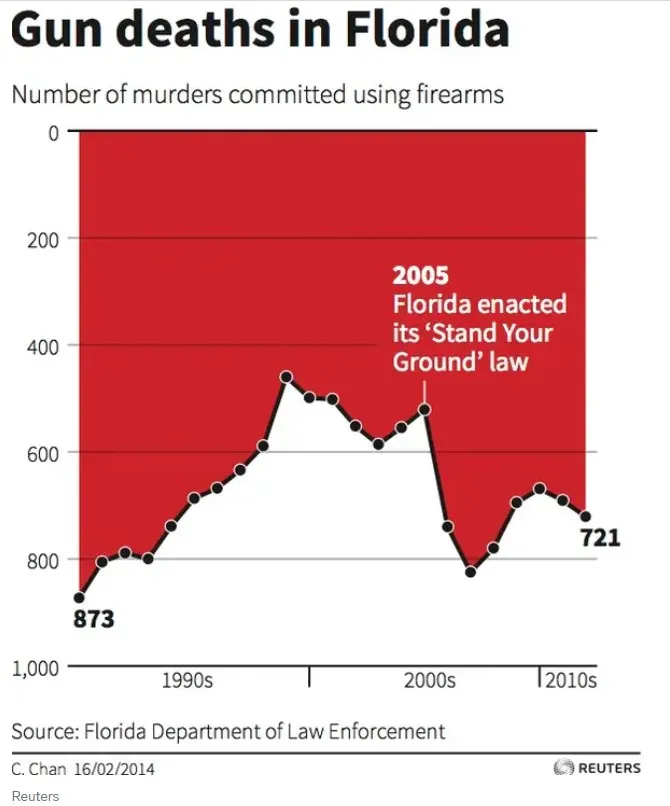

In [13]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://miro.medium.com/v2/resize:fit:4800/format:webp/1*VPRpf0YnchAwN0mjeAz4pA.jpeg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

## Create an Image Analysis Prompt

The following code constructs a **structured prompt** for analyzing an image. It sends both **text input** and an **image URL** to an AI model for interpretation.


In [14]:
image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]

In [15]:
gpt_result = openai_gpt_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=47, prompt_tokens=779, '
 'total_tokens=826, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [16]:
display(Markdown(gpt_result))

The image has a misleading y-axis. The axis starts at 600 instead of 0, which exaggerates the visual difference in the number of gun deaths over time. This can make the changes appear more dramatic than they actually are.

In [17]:
o1_result = openai_o_help(prompt=image_prompt)

('Tokens used: CompletionUsage(completion_tokens=1498, prompt_tokens=688, '
 'total_tokens=2186, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=1344, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


In [18]:
display(Markdown(o1_result))

A key issue is that the vertical axis is effectively upside‐down. The chart labels “0” at the top and “1,000” at the bottom, but then plots higher values lower down—a very counterintuitive (and misleading) way to display the data. In addition, it’s labeled “Gun deaths” though it only shows firearm murders, which can also add to confusion about what the numbers truly represent.

## 🧠 Try It Yourself: Reasoning Model Practice

Now that you’ve explored how **GPT-4o** and **OpenAI’s o1 reasoning model** handle data and images,  
try applying these models to real-world intelligence analysis scenarios.

👉 Be sure to **run every cell** you add and keep all outputs visible before submitting your notebook to GitHub.

### 1. Upload and Reason on a Text File
- Upload a short **text document** (for example, a news article, policy brief, or intelligence report).  
- Use both **GPT-4o** and **o1** to analyze the file.  
  Try questions like:
  - *“Summarize the key actors, motivations, and outcomes in this text.”*  
  - *“What potential implications could these events have on regional stability?”*  
  - *“Identify possible biases or information gaps.”*  
- Compare how each model approaches reasoning, depth, and evidence.

*(Hint: You can upload a text file in JupyterLab using the left file browser → right-click → “Upload File.” Then open and read it with Python using `open('filename.txt').read()`.)*


In [31]:
with open('Intel Report MLAI.txt', 'r', encoding='utf-8') as f:
    data_text = f.read()

print(data_text[:10000])  # show first 500 characters

data_prompt = f"""Analyze the provided data and determine 
                What potential implications does this article point out.
                Data: {data_text}"""
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

gpt_result = openai_gpt_help(prompt=data_prompt)
display(Markdown(gpt_result))

def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

o1_result = openai_o_help(prompt=data_prompt)

display(Markdown(gpt_result))


Summary

Since the December 2024 collapse of the government of Bashar Al Asad, Syrians have pursued political and economic opportunities created by the end of the country's twelve-year civil war. Internal tensions and external pressures pose obstacles to the country's transition. Interim president Ahmed Al Sharaa led a group long designated by the U.S. government as a terrorist organization. Interim authorities have outlined a five-year transitional constitutional framework after limited consultation with Syrian citizens. Elections are planned in September 2025 for a partially and indirectly elected legislative assembly. The government does not exercise control over all of Syria, with areas of the northeast under the control of ethnic Kurdish-led forces and areas south of the capital, Damascus, controlled by members of the Druze religious minority. Authorities plan to delay elections in these areas. Turkish forces remain in parts of the north, while Israeli forces have moved into forme

The article outlines several potential implications of the current situation in Syria following the collapse of Bashar Al Asad's government and the ongoing transition:

1. **Political Instability and Governance Challenges**: The interim government, led by Ahmed Al Sharaa, faces significant challenges in establishing control and governance across Syria. The lack of control over certain regions, such as those under Kurdish and Druze control, and the presence of foreign forces (Turkish and Israeli) complicate the political landscape. This fragmentation could hinder the transition to a stable and unified government.

2. **Security Concerns and Sectarian Violence**: The interim government's limited capacity to ensure security and manage sectarian violence poses a risk to the transition process. The ongoing violence and the potential for exploitation of communal tensions by opponents of the interim government could destabilize the region further.

3. **International Involvement and Influence**: The involvement of external actors, such as the United States, Turkey, and Israel, highlights the geopolitical complexities in Syria. The U.S. policy of conditional support for the interim government and its military presence in Syria indicate a continued international interest in shaping the country's future. Meanwhile, Turkey's opposition to Kurdish autonomy and Israel's military actions to protect its interests add layers of complexity to the situation.

4. **Economic Challenges and Sanctions**: The economic conditions in Syria remain dire, with energy shortages and financial pressures. While the U.S. and EU have extended sanctions relief to encourage investment, the long-term effects of misrule and the civil war pose significant hurdles to economic recovery. The potential for increased investment and trade exists, but it is contingent on political stability and effective governance.

5. **Legislative and Policy Debates in the U.S.**: Within the U.S., there is a debate over the appropriate level of support and engagement with the interim government. Some members of Congress advocate for lifting sanctions to aid recovery, while others call for a cautious approach due to concerns about the interim leaders' intentions. This debate reflects broader questions about U.S. foreign policy priorities and the balance between supporting stability and ensuring accountability in Syria.

6. **Regional Tensions and Risks of Confrontation**: The actions of neighboring countries, particularly Turkey and Israel, in pursuing their interests in Syria, raise the risk of regional tensions and potential confrontations. The complex interplay of these actors' objectives could lead to further instability and conflict in the region.

Overall, the article suggests that Syria's transition is fraught with challenges, both internal and external, that could have significant implications for the country's future stability and the broader regional dynamics. The success of the transition will depend on the ability of the interim government to navigate these challenges and the extent to which international actors can support a peaceful and inclusive political process.

('Tokens used: CompletionUsage(completion_tokens=1455, prompt_tokens=1110, '
 'total_tokens=2565, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=832, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, '
 'cached_tokens=1024))')


The article outlines several potential implications of the current situation in Syria following the collapse of Bashar Al Asad's government and the ongoing transition:

1. **Political Instability and Governance Challenges**: The interim government, led by Ahmed Al Sharaa, faces significant challenges in establishing control and governance across Syria. The lack of control over certain regions, such as those under Kurdish and Druze control, and the presence of foreign forces (Turkish and Israeli) complicate the political landscape. This fragmentation could hinder the transition to a stable and unified government.

2. **Security Concerns and Sectarian Violence**: The interim government's limited capacity to ensure security and manage sectarian violence poses a risk to the transition process. The ongoing violence and the potential for exploitation of communal tensions by opponents of the interim government could destabilize the region further.

3. **International Involvement and Influence**: The involvement of external actors, such as the United States, Turkey, and Israel, highlights the geopolitical complexities in Syria. The U.S. policy of conditional support for the interim government and its military presence in Syria indicate a continued international interest in shaping the country's future. Meanwhile, Turkey's opposition to Kurdish autonomy and Israel's military actions to protect its interests add layers of complexity to the situation.

4. **Economic Challenges and Sanctions**: The economic conditions in Syria remain dire, with energy shortages and financial pressures. While the U.S. and EU have extended sanctions relief to encourage investment, the long-term effects of misrule and the civil war pose significant hurdles to economic recovery. The potential for increased investment and trade exists, but it is contingent on political stability and effective governance.

5. **Legislative and Policy Debates in the U.S.**: Within the U.S., there is a debate over the appropriate level of support and engagement with the interim government. Some members of Congress advocate for lifting sanctions to aid recovery, while others call for a cautious approach due to concerns about the interim leaders' intentions. This debate reflects broader questions about U.S. foreign policy priorities and the balance between supporting stability and ensuring accountability in Syria.

6. **Regional Tensions and Risks of Confrontation**: The actions of neighboring countries, particularly Turkey and Israel, in pursuing their interests in Syria, raise the risk of regional tensions and potential confrontations. The complex interplay of these actors' objectives could lead to further instability and conflict in the region.

Overall, the article suggests that Syria's transition is fraught with challenges, both internal and external, that could have significant implications for the country's future stability and the broader regional dynamics. The success of the transition will depend on the ability of the interim government to navigate these challenges and the extent to which international actors can support a peaceful and inclusive political process.

### 2. Try Another Image
- Replace the existing image URL with a **different image**, such as a map, protest photo, or satellite image.  
- Ask both models:
  - *“What do you observe in this image?”*  
  - *“What might this image imply in a geopolitical or social context?”*  
- Note differences in how **GPT-4o** and **o1** reason about visual clues.

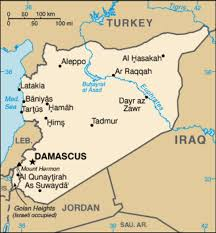

('Tokens used: CompletionUsage(completion_tokens=89, prompt_tokens=269, '
 'total_tokens=358, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


The image is a map of Syria and its surrounding regions. The issue with this map is the labeling of the "Golan Heights" as "Golan Heights (Israeli occupied)." This is a politically sensitive topic, as the Golan Heights is a disputed territory. It was captured by Israel from Syria in 1967 and later annexed, a move not recognized by most of the international community. The labeling reflects a particular political perspective.

('Tokens used: CompletionUsage(completion_tokens=4663, prompt_tokens=238, '
 'total_tokens=4901, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=4544, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


It is essentially a simplified “CIA‐style” reference map rather than a fully detailed political or administrative map of Syria, and it omits several major Syrian provincial capitals (notably Daraa and Idlib). In other words, there is nothing blatantly “wrong” about the borders themselves, but important cities and provinces are missing, and some place‐names use older or less‐common transliterations (for example, “Hims” instead of “Homs”). Consequently, it does not reflect Syria’s complete internal geography.

In [35]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQIADgJiXZMlfRO6d0kF2X4nzQlVZ6vA6vsSA&s"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img.show()

image_prompt = [
                    {"type": "text", "text": 'what is wrong with this image?'},
                    {"type": "image_url", "image_url": {
                        "url": image_url}
                    }
                ]
gpt_result = openai_gpt_help(prompt=image_prompt)
display(Markdown(gpt_result))
o1_result = openai_o_help(prompt=image_prompt)
display(Markdown(o1_result))


### 3. Compare Reasoning Quality
- Pose a challenging **analytical or logical question** to both models, such as:
  - *“Which country is likely to gain the most influence from this event and why?”*  
  - *“Given these statements, which scenario is more probable?”*  
- Before asking, provide the model with **sufficient context**, for example:
  - A short paragraph summarizing the situation or event.  
  - Key actors, timeline, and relevant evidence (from your uploaded text file or your own notes).  
- Observe how the **o1 model’s step-by-step reasoning** differs from GPT-4o’s concise response.  
  Consider whether detailed reasoning produces **stronger analytic insights** or introduces **new assumptions**.

In [36]:
data_prompt = f"""Analyze the provided data and determine 
                What is the most probable scenario for Syria.
                Data: {data_text}"""
def openai_gpt_help(prompt):
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='gpt-4o',
        messages=messages,
        temperature = 0
    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

gpt_result = openai_gpt_help(prompt=data_prompt)
display(Markdown(gpt_result))

def openai_o_help(prompt):
    messages = [ {"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model='o1',
        reasoning_effort="high", # low, medium or high
        messages=messages,

    )
    token_usage = response.usage
    
    pprint(f"Tokens used: {token_usage}")

    return response.choices[0].message.content

o1_result = openai_o_help(prompt=data_prompt)

display(Markdown(gpt_result))


('Tokens used: CompletionUsage(completion_tokens=524, prompt_tokens=1111, '
 'total_tokens=1635, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


Based on the provided data, the most probable scenario for Syria involves a complex and challenging transition period characterized by several key dynamics:

1. **Political Transition and Governance Challenges**: The interim government, led by Ahmed Al Sharaa, is attempting to navigate a delicate political transition following the collapse of Bashar Al Asad's regime. The outlined five-year transitional constitutional framework and planned elections in September 2025 indicate a move towards establishing a new political order. However, the government's limited control over the entire country, particularly in areas controlled by Kurdish-led forces and the Druze minority, poses significant governance challenges. The delay in elections in these regions further complicates the transition.

2. **Security and Sectarian Tensions**: The interim government faces ongoing security challenges, including sectarian violence and the presence of foreign forces. The involvement of Turkish and Israeli forces, along with the activities of the Syrian Democratic Forces (SDF), adds layers of complexity to the security landscape. The interim government's limited capacity to ensure security and manage sectarian tensions could undermine its legitimacy and stability.

3. **External Influences and International Relations**: The involvement of external actors, such as the United States, Turkey, and Israel, significantly influences Syria's transition. The U.S. policy of conditional support for the interim government, coupled with sanctions relief, aims to stabilize the country and encourage inclusivity. However, Turkey's opposition to Kurdish autonomy and Israel's military actions in southern Syria highlight the geopolitical tensions that could impact Syria's future.

4. **Economic Recovery and Sanctions**: Syria's economic recovery is hindered by energy shortages, financial pressures, and the legacy of misrule and sanctions. While the easing of some sanctions offers opportunities for investment and growth, the economic situation remains precarious. The interim government's ability to address these economic challenges will be crucial for its success.

5. **Legislative and Policy Uncertainty**: In the U.S., there is ongoing debate over the appropriate level of support and sanctions for Syria. The Trump Administration's actions to remove some sanctions and revise others reflect a strategic approach to influence Syria's transition. However, legislative uncertainty and differing opinions in Congress could affect the consistency and effectiveness of U.S. policy.

In summary, the most probable scenario for Syria involves a fragile and contested transition period marked by political, security, and economic challenges. The interim government's ability to navigate these challenges, manage external influences, and foster inclusivity and stability will be critical to determining Syria's future trajectory. The situation remains fluid, with potential for both progress and setbacks depending on the actions of domestic and international stakeholders.

('Tokens used: CompletionUsage(completion_tokens=1542, prompt_tokens=1110, '
 'total_tokens=2652, '
 'completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, '
 'audio_tokens=0, reasoning_tokens=960, rejected_prediction_tokens=0), '
 'prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))')


Based on the provided data, the most probable scenario for Syria involves a complex and challenging transition period characterized by several key dynamics:

1. **Political Transition and Governance Challenges**: The interim government, led by Ahmed Al Sharaa, is attempting to navigate a delicate political transition following the collapse of Bashar Al Asad's regime. The outlined five-year transitional constitutional framework and planned elections in September 2025 indicate a move towards establishing a new political order. However, the government's limited control over the entire country, particularly in areas controlled by Kurdish-led forces and the Druze minority, poses significant governance challenges. The delay in elections in these regions further complicates the transition.

2. **Security and Sectarian Tensions**: The interim government faces ongoing security challenges, including sectarian violence and the presence of foreign forces. The involvement of Turkish and Israeli forces, along with the activities of the Syrian Democratic Forces (SDF), adds layers of complexity to the security landscape. The interim government's limited capacity to ensure security and manage sectarian tensions could undermine its legitimacy and stability.

3. **External Influences and International Relations**: The involvement of external actors, such as the United States, Turkey, and Israel, significantly influences Syria's transition. The U.S. policy of conditional support for the interim government, coupled with sanctions relief, aims to stabilize the country and encourage inclusivity. However, Turkey's opposition to Kurdish autonomy and Israel's military actions in southern Syria highlight the geopolitical tensions that could impact Syria's future.

4. **Economic Recovery and Sanctions**: Syria's economic recovery is hindered by energy shortages, financial pressures, and the legacy of misrule and sanctions. While the easing of some sanctions offers opportunities for investment and growth, the economic situation remains precarious. The interim government's ability to address these economic challenges will be crucial for its success.

5. **Legislative and Policy Uncertainty**: In the U.S., there is ongoing debate over the appropriate level of support and sanctions for Syria. The Trump Administration's actions to remove some sanctions and revise others reflect a strategic approach to influence Syria's transition. However, legislative uncertainty and differing opinions in Congress could affect the consistency and effectiveness of U.S. policy.

In summary, the most probable scenario for Syria involves a fragile and contested transition period marked by political, security, and economic challenges. The interim government's ability to navigate these challenges, manage external influences, and foster inclusivity and stability will be critical to determining Syria's future trajectory. The situation remains fluid, with potential for both progress and setbacks depending on the actions of domestic and international stakeholders.

## References  
- **OpenAI Reasoning Models Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning)  
- **OpenAI Reasoning Models Best Practices Guide**: [OpenAI](https://platform.openai.com/docs/guides/reasoning-best-practices)  
- **Colin Jarvis. “Reasoning with O1.” DeepLearning.AI.** Accessed February 14, 2025. [DeepLearning.AI](https://www.deeplearning.ai/short-courses/reasoning-with-o1/)  